In [22]:
import pandas as pd
import matplotlib.pyplot as plot

# 1. Modelo XGBoost

In [23]:
data = pd.read_excel(r"./demandaHistorica.xlsx")
data

,FECHA,Energía SADI (GWh),Potencia Pico SADI (MW),DIA,TIPO DIA,VERANO / INVIERNO,T Media GBA (°C),Claro/Nublado/Seminublado
0,2007-01-01,277.581153,14157.0,Lunes,FERIADO,VERANO,29.2,C
1,2007-01-02,325.393852,15801.0,Martes,HÁBIL,VERANO,26.01,N
2,2007-01-03,325.492540,16136.0,Miércoles,HÁBIL,VERANO,25,N
3,2007-01-04,334.033576,16782.0,Jueves,HÁBIL,VERANO,25,N
4,2007-01-05,320.328528,15321.0,Viernes,HÁBIL,VERANO,22.6,C
...,...,...,...,...,...,...,...,...
6001,2023-06-07,399.412437,19646.0,Miércoles,HÁBIL,INVIERNO,18.4,N
6002,2023-06-08,391.938465,19004.0,Jueves,HÁBIL,INVIERNO,21.8,N
6003,2023-06-09,391.815378,19758.0,Viernes,HÁBIL,INVIERNO,18,N
6004,2023-06-10,405.336796,20424.0,Sábado,SÁBADO,INVIERNO,10.6,N


### 1.1 Generación de Features

In [24]:
data["day_of_week"] = data["FECHA"].dt.dayofweek
data["day_of_year"] = data["FECHA"].dt.dayofyear
data["month"] = data["FECHA"].dt.month
data["quarter"] = data["FECHA"].dt.quarter
data["year"] = data["FECHA"].dt.year

data.head()

,FECHA,Energía SADI (GWh),Potencia Pico SADI (MW),DIA,TIPO DIA,VERANO / INVIERNO,T Media GBA (°C),Claro/Nublado/Seminublado,day_of_week,day_of_year,month,quarter,year
0,2007-01-01,277.581153,14157.0,Lunes,FERIADO,VERANO,29.2,C,0,1,1,1,2007
1,2007-01-02,325.393852,15801.0,Martes,HÁBIL,VERANO,26.01,N,1,2,1,1,2007
2,2007-01-03,325.492540,16136.0,Miércoles,HÁBIL,VERANO,25,N,2,3,1,1,2007
3,2007-01-04,334.033576,16782.0,Jueves,HÁBIL,VERANO,25,N,3,4,1,1,2007
4,2007-01-05,320.328528,15321.0,Viernes,HÁBIL,VERANO,22.6,C,4,5,1,1,2007


### 1.2 Separación entre Train y Test

In [25]:
training_data = data.loc[data["FECHA"] < "2022-06-11"]
print(training_data.shape)

testing_data = data.loc[data["FECHA"] >= "2022-06-11"]
print(testing_data.shape)

(5640, 13)
(366, 13)


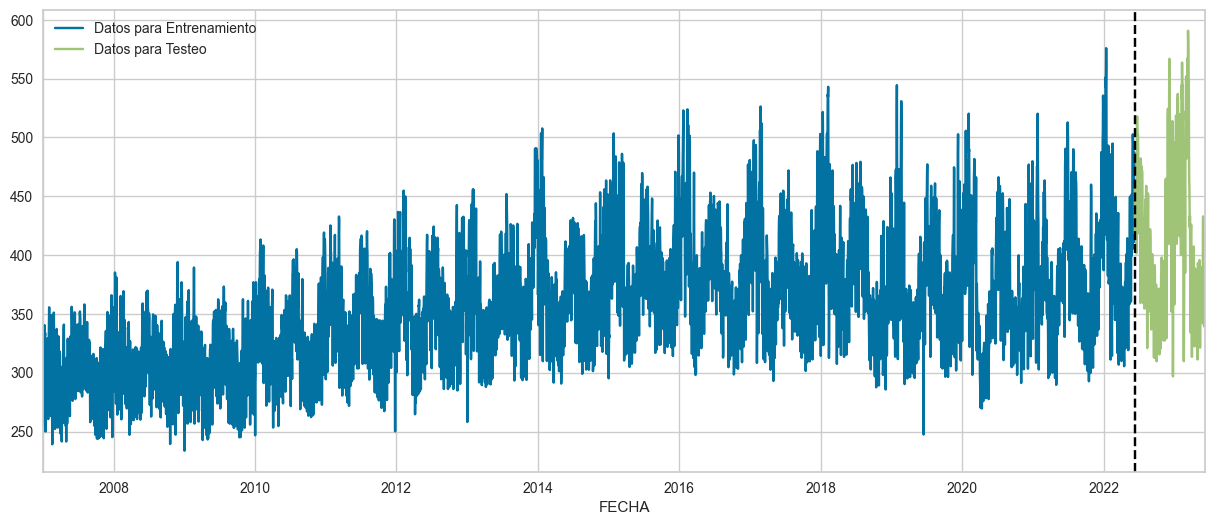

In [26]:
figure, ax = plot.subplots(figsize=(15, 6))
training_data.plot(ax=ax, label="Datos para Entrenamiento", x="FECHA", y="Energía SADI (GWh)")
testing_data.plot(ax=ax, label="Datos para Testeo", x="FECHA", y="Energía SADI (GWh)")
ax.axvline(x="2022-06-11", color="black", linestyle="--")
plot.show()

In [27]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["FECHA"])
testing_dates = testing_data["FECHA"]
testing_data = testing_data.drop(columns=["FECHA"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["Energía SADI (GWh)"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["Energía SADI (GWh)"]

In [28]:
X_train

,day_of_week,day_of_year,month,quarter,year
0,0,1,1,1,2007
1,1,2,1,1,2007
2,2,3,1,1,2007
3,3,4,1,1,2007
4,4,5,1,1,2007
...,...,...,...,...,...
5635,0,157,6,2,2022
5636,1,158,6,2,2022
5637,2,159,6,2,2022
5638,3,160,6,2,2022


In [29]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plot.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plot.legend(["Actual", "Prediction"])
  plot.show()

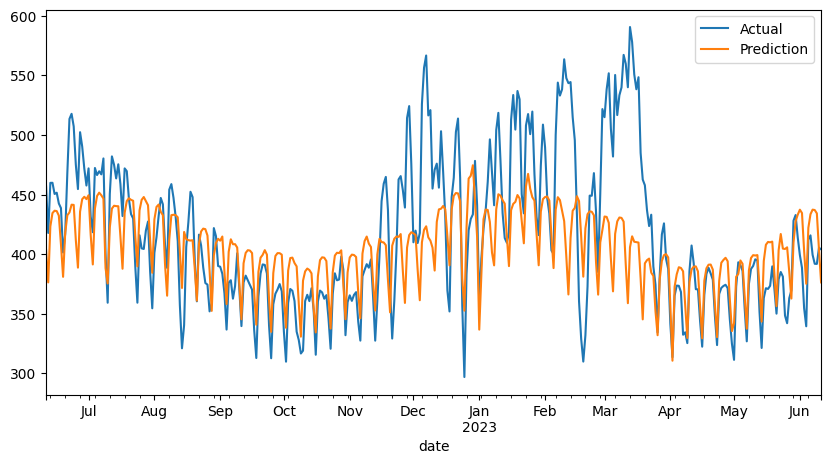

MAE: 37.70099070346979
MSE: 2632.899543465011
MAPE: 0.0855605457163599


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)